# Phase 3 - Modeling

**Note 1: the following starting code only generates a single random train/test split when default_seed is used. You need to modify the code to generate 100 independent train/test splits with different seeds and report the average results on those independent splits along with standard deviation.**

**Note 2: You are completely free to use your own implementation.**

In [1]:
# Load general utilities
# ----------------------
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import datetime
import numpy as np
import pickle
import time
import seaborn as sns

# Load sklearn utilities
# ----------------------
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, mean_squared_error, r2_score

from sklearn.calibration import calibration_curve

# Load classifiers
# ----------------
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier

# Other Packages
# --------------
from scipy.stats import kendalltau
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
from scipy.interpolate import spline

# Load debugger, if required
#import pixiedust
pd.options.mode.chained_assignment = None #'warn'

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Define a function that, given a CVGridSearch object, finds the
# percentage difference between the best and worst scores
def find_score_variation(cv_model):
    all_scores = cv_model.cv_results_['mean_test_score']
    return( np.abs((max(all_scores) - min(all_scores))) * 100 / max(all_scores) )

    '''
    which_min_score = np.argmin(all_scores)
    
    all_perc_diff = []
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score - 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score + 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    return ( np.mean(all_perc_diff) )
    '''

# Define a function that checks, given a CVGridSearch object,
# whether the optimal parameters lie on the edge of the search
# grid
def find_opt_params_on_edge(cv_model):
    out = False
    
    for i in cv_model.param_grid:
        if cv_model.best_params_[i] in [ cv_model.param_grid[i][0], cv_model.param_grid[i][-1] ]:
            out = True
            break
            
    return out

## Define a default random seed and an output file

In [3]:
default_seed = 1
output_file = "output_sample"

In [4]:
# Create a function to print a line to our output file

def dump_to_output(key, value):
    with open(output_file, "a") as f:
        f.write(",".join([str(default_seed), key, str(value)]) + "\n")

## Load the data and engineer the features

In [5]:
# Read the data and features from the pickle file saved in CS-Phase 2
data, discrete_features, continuous_features, ret_cols = pickle.load( open( "clean_data.pickle", "rb" ) )

In [6]:
## Create the outcome columns: True if loan_status is either Charged Off or Default, False otherwise
data["outcome"] = False
data["outcome"][data["loan_status"]=="Default"]=True
data["outcome"][data["loan_status"]=="Charged Off"]=True

In [7]:
# Create a feature for the length of a person's credit history at the time the loan is issued
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
continuous_features.append('cr_hist')

In [8]:
# Randomly assign each row to a training and test set. We do this now because we will be fitting a variety of models on various time periods, and we would like every period to use the *same* training/test split
np.random.seed(default_seed)
## create the train columns where the value is True if it is a train instance and False otherwise. Hint: use np.random.choice with 70% for training and 30% for testing
data['train'] = np.random.choice([True, False], len(data), p=[0.7, 0.3])

In [9]:
# Create a matrix of features and outcomes, with dummies. Record the names of the dummies for later use
X_continuous = data[continuous_features].values

X_discrete = pd.get_dummies(data[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
discrete_features_dummies = X_discrete.columns.tolist()
X_discrete = X_discrete.values

X = np.concatenate( (X_continuous, X_discrete), axis = 1 )

y = data.outcome.values

train = data.train.values

In [10]:
data

,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,...,last_pymnt_d,loan_length,term_num,ret_PESS,ret_OPT,ret_INTa,ret_INTb,outcome,cr_hist,train
0,1077501,5000.0,5000.0,36 months,10.65,162.87,B,10+ years,RENT,24000.00,...,2015-01-01,37.027454,36,0.057544,0.055988,0.054605,0.088148,False,322.963511,True
1,1077430,2500.0,2500.0,60 months,15.27,59.83,C,< 1 year,RENT,30000.00,...,2013-04-01,16.000329,60,-0.118838,-0.118838,-0.110200,-0.095511,True,152.019549,False
2,1077175,2400.0,2400.0,36 months,15.96,84.33,C,10+ years,RENT,12252.00,...,2014-06-01,29.996509,36,0.084120,0.100944,0.073803,0.113007,False,120.971683,True
3,1076863,10000.0,10000.0,36 months,13.49,339.31,C,10+ years,RENT,49200.00,...,2015-01-01,37.027454,36,0.074396,0.072386,0.065582,0.100571,False,189.966940,True
4,1075358,3000.0,3000.0,60 months,12.69,67.79,B,1 year,RENT,80000.00,...,2017-01-01,61.044375,60,0.071127,0.069961,0.087479,0.114530,False,190.985441,True
5,1075269,5000.0,5000.0,36 months,7.90,156.46,A,3 years,RENT,36000.00,...,2015-01-01,37.027454,36,0.042147,0.041008,0.044576,0.076798,False,84.962730,True
6,1069639,7000.0,7000.0,60 months,15.96,170.08,C,8 years,RENT,47004.00,...,2016-05-01,52.994928,60,0.089653,0.101493,0.109539,0.142469,False,77.011848,True
7,1072053,3000.0,3000.0,36 months,18.64,109.43,E,9 years,RENT,48000.00,...,2015-01-01,37.027454,36,0.104348,0.101528,0.085092,0.122652,False,58.974517,True
8,1071795,5600.0,5600.0,60 months,21.28,152.39,F,4 years,OWN,40000.00,...,2012-04-01,4.008296,60,-0.176875,-0.176875,-0.174082,-0.169262,True,91.993675,True
9,1071570,5375.0,5375.0,60 months,12.69,121.45,B,< 1 year,RENT,15000.00,...,2012-11-01,11.039241,60,-0.144759,-0.144759,-0.138579,-0.128011,True,86.966878,True


## Prepare functions to fit and evaluate models

In [11]:
def prepare_data(data_subset = np.array([True]*len(data)),
                    n_samples_train = 30000,
                    n_samples_test = 20000,
                    feature_subset = None,
                    date_range_train = (data.issue_d.min(), data.issue_d.max()),
                    date_range_test = (data.issue_d.min(), data.issue_d.max()),
                    random_state = default_seed):
    '''
    This function will prepare the data for classification or regression.
    It expects the following parameters:
      - data_subset: a numpy array with as many entries as rows in the
                     dataset. Each entry should be True if that row
                     should be used, or False if it should be ignored
      - n_samples_train: the total number of samples to be used for training.
                         Will trigger an error if this number is larger than
                         the number of rows available after all filters have
                         been applied
      - n_samples_test: as above for testing
      - feature_subect: A list containing the names of the features to be
                        used in the model. In None, all features in X are
                        used
      - date_range_train: a tuple containing two dates. All rows with loans
                          issued outside of these two dates will be ignored in
                          training
      - date_range_test: as above for testing
      - random_state: the random seed to use when selecting a subset of rows
      
    Note that this function assumes the data has a "Train" column, and will
    select all training rows from the rows with "True" in that column, and all
    the testing rows from those with a "False" in that column.
    
    This function returns a dictionary with the following entries
      - X_train: the matrix of training data
      - y_train: the array of training labels
      - train_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the train set
      - X_test: the matrix of testing data
      - y_test: the array of testing labels
      - test_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the test set
    '''
    
    np.random.seed(random_state)
        
    # Filter down the data to the required date range, and downsample
    # as required
    filter_train = ( train & (data.issue_d >= date_range_train[0]) &
                            (data.issue_d <= date_range_train[1]) & data_subset ).values
    filter_test = ( (train == False) & (data.issue_d >= date_range_test[0])
                            & (data.issue_d <= date_range_test[1]) & data_subset ).values
    
    filter_train[ np.random.choice( np.where(filter_train)[0], size = filter_train.sum()
                                                   - n_samples_train, replace = False ) ] = False
    filter_test[ np.random.choice( np.where(filter_test)[0], size = filter_test.sum()
                                                   - n_samples_test, replace = False ) ] = False
    
    # Prepare the training and test set
    X_train = X[ filter_train , :]
    X_test = X[ filter_test, :]
    if feature_subset != None:
        cols = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in feature_subset]
        X_train = X_train[ : , cols ]
        X_test = X_test[ : , cols ]
        
    y_train = y[ filter_train ]
    y_test = y[ filter_test ]
    
    # Scale the variables
    scaler = preprocessing.MinMaxScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # return training and testing data
    out = {'X_train':X_train, 'y_train':y_train, 'train_set':filter_train, 
           'X_test':X_test, 'y_test':y_test, 'test_set':filter_test}
    
    return out

In [12]:
def fit_classification(model, data_dict,
                          cv_parameters = {},
                          model_name = None,
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True):
    '''
    This function will fit a classification model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    If the model provided does not have a predict_proba function, we will
    simply print accuracy diagnostics and return.
    
    If the model provided does have a predict_proba function, we first
    figure out the optimal threshold that maximizes the accuracy and
    print out accuracy diagnostics. We then print an ROC curve, sensitivity/
    specificity curve, and calibration curve.
    
    This function returns a dictionary with the following entries
      - model: the best fitted model
      - y_pred: predictions for the test set
      - y_pred_probs: probability predictions for the test set, if the model
                      supports them
      - y_pred_score: prediction scores for the test set, if the model does not 
                      output probabilities.
    '''
        
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    X_train = data_dict['X_train']
    y_train = data_dict['y_train']
    
    X_test = data_dict['X_test']
    y_test = data_dict['y_test']
    
    filter_train = data_dict['train_set']    
  
    # --------------------------
    #   Step 2 - Fit the model
    # --------------------------

    cv_model = GridSearchCV(model, cv_parameters)
    
    start_time = time.time()
    cv_model.fit(X_train, y_train)
    end_time = time.time()
    
    best_model = cv_model.best_estimator_
    
    if print_to_screen:

        if model_name != None:
            print("=========================================================")
            print("  Model: " + model_name)
            print("=========================================================")

        print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
        print("Optimal parameters:")
        print(cv_model.best_params_)
        print("")
    
    # -------------------------------
    #   Step 3 - Evaluate the model
    # -------------------------------
    
    # If possible, make probability predictions
    try:
        y_pred_probs = best_model.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
        
        probs_predicted = True
    except:
        probs_predicted = False
    
    # Make predictions; if we were able to find probabilities, use
    # the threshold that maximizes the accuracy in the training set.
    # If not, just use the learner's predict function
    if probs_predicted:
        y_train_pred_probs = best_model.predict_proba(X_train)[:,1]
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)
        
        true_pos_train = tpr_train*(y_train.sum())
        true_neg_train = (1 - fpr_train) *(1-y_train).sum()
        
        best_threshold_index = np.argmax(true_pos_train + true_neg_train)
        best_threshold = 1 if best_threshold_index == 0 else thresholds_train[ best_threshold_index ]
        
        if print_to_screen:
            print("Accuracy-maximizing threshold was: " + str(best_threshold))
        
        y_pred = (y_pred_probs > best_threshold)
    else:
        y_pred = best_model.predict(X_test)
    
    if print_to_screen:
        print("Accuracy: ", accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred, target_names =['No default', 'Default'], digits = 4))

    if print_to_screen:
        if probs_predicted:        
            plt.figure(figsize = (13, 4.5))
            plt.subplot(2, 2, 1)

            plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_pred_probs))
            plt.plot(fpr, tpr, 'b')
            plt.plot([0,1],[0,1],'r--')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')

            plt.subplot(2, 2, 3)

            plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
            plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
            plt.legend(loc = 'lower right')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.xlabel('Threshold')

            plt.subplot(2, 2, 2)

            fp_0, mpv_0 = calibration_curve(y_test, y_pred_probs, n_bins = 10)
            plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
            plt.plot(mpv_0, fp_0, 's-')
            plt.ylabel('Fraction of Positives')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.legend(loc ='upper left')
            
            plt.subplot(2, 2, 4)
            plt.hist(y_pred_probs, range=(0, 1), bins=10, histtype="step", lw=2)
            plt.xlim([0,1]); plt.ylim([0,20000])
            plt.xlabel('Mean Predicted Probability')
            plt.ylabel('Count')
            
            #plt.tight_layout()
            plt.show()
        
    # Additional Score Check
    if probs_predicted:
        y_train_score = y_train_pred_probs
    else:
        y_train_score = best_model.decision_function(X_train)
        
    tau, p_value = kendalltau(y_train_score, data.grade[filter_train])
    if print_to_screen:
        print("")
        print("Similarity to LC grade ranking: ", tau)
    
    if probs_predicted:
        brier_score = brier_score_loss(y_test, y_pred_probs)
        if print_to_screen:
            print("Brier score:", brier_score)
    
    # Return the model predictions, and the
    # test set
    # -------------------------------------
    out = {'model':best_model, 'y_pred_labels':y_pred}
    
    if probs_predicted:
        out.update({'y_pred_probs':y_pred_probs})
    else:
        y_pred_score = best_model.decision_function(X_test)
        out.update({'y_pred_score':y_pred_score})
        
    # Output results to file
    # ----------------------
    if probs_predicted and output_to_file:
        # Check whether any of the CV parameters are on the edge of
        # the search space
        opt_params_on_edge = find_opt_params_on_edge(cv_model)
        dump_to_output(model_name + "::search_on_edge", opt_params_on_edge)
        if print_to_screen:
            print("Were parameters on edge? : " + str(opt_params_on_edge))
        
        # Find out how different the scores are for the different values
        # tested for by cross-validation. If they're not too different, then
        # even if the parameters are off the edge of the search grid, we should
        # be ok
        score_variation = find_score_variation(cv_model)
        dump_to_output(model_name + "::score_variation", score_variation)
        if print_to_screen:
            print("Score variations around CV search grid : " + str(score_variation))
        
        # Print out all the scores
        dump_to_output(model_name + "::all_cv_scores", str(cv_model.cv_results_['mean_test_score']))
        if print_to_screen:
            print( str(cv_model.cv_results_['mean_test_score']) )
        
        # Dump the AUC to file
        dump_to_output(model_name + "::roc_auc", roc_auc_score(y_test, y_pred_probs) )
        
    return out

## Train and Test different machine learning classification models

The machine learning models listed in the following are just our suggestions. You are free to try any other models that you would like to experiment with.

In [14]:
## define your set of features to use in different models
your_features = ['loan_amnt', 'funded_amnt', 'term', 'int_rate', 'installment', 'grade', 'emp_length',
'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status',
'purpose', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'open_acc', 'pub_rec',
'fico_range_high', 'fico_range_low', 'revol_bal', 'revol_util', 'total_pymnt',
'last_pymnt_d', 'recoveries']
# prepare the train, test data for training models
data_dict = prepare_data(feature_subset = your_features)

all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in your_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

### Naive Bayes

  Model: Naive Bayes Classifier
Fit time: 0.62 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 1
Accuracy:  0.7943
              precision    recall  f1-score   support

  No default     0.7943    1.0000    0.8854     15886
     Default     0.0000    0.0000    0.0000      4114

   micro avg     0.7943    0.7943    0.7943     20000
   macro avg     0.3972    0.5000    0.4427     20000
weighted avg     0.6309    0.7943    0.7032     20000



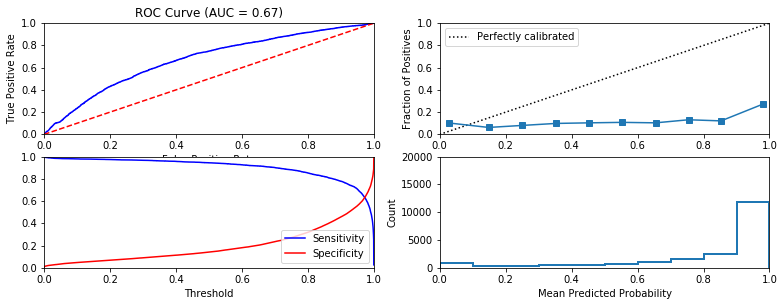


Similarity to LC grade ranking:  0.6834094429501434
Brier score: 0.5758275258661394
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.4407]


In [15]:
## Train and test a naive bayes classifier

gnb = GaussianNB()
gnb = fit_classification(gnb, data_dict, model_name="Naive Bayes Classifier")

### $l_1$ regularized logistic regression

  Model: L1 regularized logistic regression
Fit time: 52.17 seconds
Optimal parameters:
{'C': 0.01}

Accuracy-maximizing threshold was: 0.4351460562383423
Accuracy:  0.7939
              precision    recall  f1-score   support

  No default     0.7964    0.9949    0.8846     15886
     Default     0.4740    0.0177    0.0342      4114

   micro avg     0.7939    0.7939    0.7939     20000
   macro avg     0.6352    0.5063    0.4594     20000
weighted avg     0.7301    0.7939    0.7097     20000



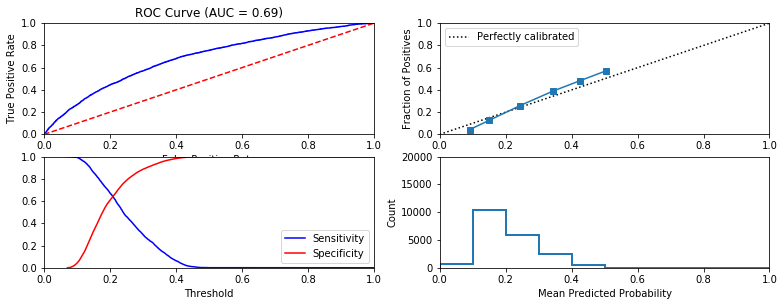


Similarity to LC grade ranking:  0.6827335268590659
Brier score: 0.15215152967986476
Were parameters on edge? : True
Score variations around CV search grid : 0.1466091400326707
[0.79576667 0.7946     0.7953     0.79506667 0.7952    ]


In [16]:
## Train and test a l_1 regularized logistic regression classifier

l1_logistic = LogisticRegression(penalty='l1')
cv_parameters = {'C': [0.01, 0.1, 1, 10, 100]}

l1_logistic = fit_classification(l1_logistic, data_dict, cv_parameters, 'L1 regularized logistic regression')

### $l_2$ regularized logistic regression

  Model: L2 regularized logistic regression
Fit time: 6.7 seconds
Optimal parameters:
{'C': 0.01}

Accuracy-maximizing threshold was: 0.47192995451768566
Accuracy:  0.7956
              precision    recall  f1-score   support

  No default     0.7972    0.9960    0.8856     15886
     Default     0.5855    0.0216    0.0417      4114

   micro avg     0.7956    0.7956    0.7956     20000
   macro avg     0.6914    0.5088    0.4637     20000
weighted avg     0.7537    0.7956    0.7120     20000



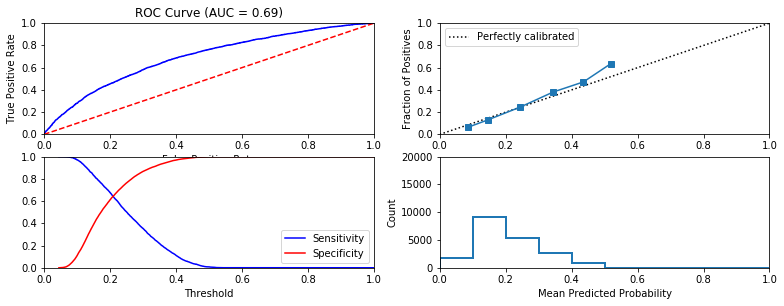


Similarity to LC grade ranking:  0.6923614513656947
Brier score: 0.15078368376694706
Were parameters on edge? : True
Score variations around CV search grid : 0.1005488290250982
[0.79563333 0.79493333 0.79483333 0.79526667 0.79526667]


In [17]:
## Train and test a l_2 regularized logistic regression classifier

l2_logistic = LogisticRegression(penalty='l2')
cv_parameters = {'C': [0.01, 0.1, 1, 10, 100]}

l2_logistic = fit_classification(l2_logistic, data_dict, cv_parameters, 'L2 regularized logistic regression')

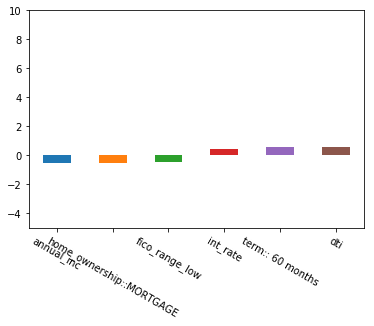

In [18]:
## plot top 3 features with the most positive (and negative) weights 
top_and_bottom_idx = list(np.argsort(l2_logistic['model'].coef_)[0,:3]) + list(np.argsort(l2_logistic['model'].coef_)[0,-3:])
bplot = pd.Series(l2_logistic['model'].coef_[0,top_and_bottom_idx])
xticks = selected_features[top_and_bottom_idx]
p1 = bplot.plot(kind='bar',rot=-30,ylim=(-5,10))
p1.set_xticklabels(xticks)
plt.show()

### Decision tree

  Model: Decision tree
Fit time: 7.97 seconds
Optimal parameters:
{'criterion': 'entropy', 'max_depth': 4}

Accuracy-maximizing threshold was: 1
Accuracy:  0.7943
              precision    recall  f1-score   support

  No default     0.7943    1.0000    0.8854     15886
     Default     0.0000    0.0000    0.0000      4114

   micro avg     0.7943    0.7943    0.7943     20000
   macro avg     0.3972    0.5000    0.4427     20000
weighted avg     0.6309    0.7943    0.7032     20000



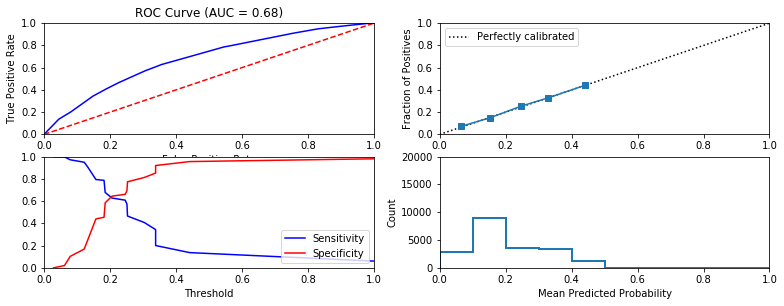


Similarity to LC grade ranking:  0.7884806966310701
Brier score: 0.15251531646569433
Were parameters on edge? : True
Score variations around CV search grid : 1.5488582941571496
[0.7933     0.79326667 0.7885     0.7854     0.78193333 0.79413333
 0.79316667 0.7925     0.78876667 0.78183333]


In [21]:
## Train and test a decision tree classifier

decision_tree = DecisionTreeClassifier()
cv_parameters = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8]}

decision_tree = fit_classification(decision_tree, data_dict, cv_parameters, 'Decision tree')

### Random forest

  Model: Random forest
Fit time: 1435.5 seconds
Optimal parameters:
{'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 500}

Accuracy-maximizing threshold was: 0.3883290158097879
Accuracy:  0.79575
              precision    recall  f1-score   support

  No default     0.8075    0.9755    0.8835     15886
     Default     0.5179    0.1018    0.1702      4114

   micro avg     0.7957    0.7957    0.7957     20000
   macro avg     0.6627    0.5386    0.5269     20000
weighted avg     0.7479    0.7957    0.7368     20000



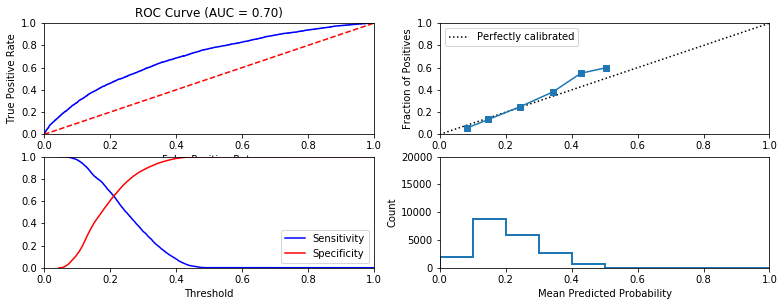


Similarity to LC grade ranking:  0.7647312150885051
Brier score: 0.1504837786629412
Were parameters on edge? : True
Score variations around CV search grid : 0.05024915204556764
[0.79576667 0.79576667 0.79576667 0.79576667 0.79576667 0.79576667
 0.79576667 0.79576667 0.79576667 0.79576667 0.79576667 0.79576667
 0.79576667 0.79573333 0.7958     0.79576667 0.79576667 0.79576667
 0.796      0.7959     0.79576667 0.79576667 0.7957     0.79583333
 0.7958     0.79583333 0.7959     0.79563333 0.79573333 0.79583333
 0.79576667 0.79576667 0.79576667 0.79576667 0.79576667 0.79576667
 0.79576667 0.79576667 0.79576667 0.79576667 0.79576667 0.79576667
 0.79576667 0.79573333 0.7958     0.79576667 0.79576667 0.79576667
 0.79563333 0.79583333 0.79583333 0.79586667 0.79573333 0.79573333
 0.79586667 0.79603333 0.79593333 0.79596667 0.79583333 0.79583333]


In [22]:
## Train and test a random forest classifier

random_forest = RandomForestClassifier()
cv_parameters = {'n_estimators': [200, 500],
                'max_features': ['auto', 'sqrt', 'log2'],
                'max_depth' : [4,5,6,7,8],
                'criterion' :['gini', 'entropy']}

random_forest = fit_classification(random_forest, data_dict, cv_parameters, 'Random forest')

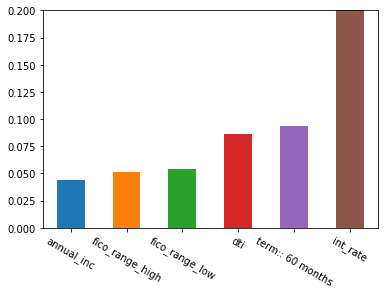

In [23]:
## Plot top 6 most significant features
top_idx = list(np.argsort(random_forest['model'].feature_importances_)[-6:]) 
bplot = pd.Series(random_forest['model'].feature_importances_[top_idx])
xticks = selected_features[top_idx]
p2 = bplot.plot(kind='bar',rot=-30,ylim=(0,0.2))
p2.set_xticklabels(xticks)
plt.show()

### Multi-layer perceptron

  Model: Multi-layer perceptron
Fit time: 6108.0 seconds
Optimal parameters:
{'alpha': 0.001, 'hidden_layer_sizes': 5, 'max_iter': 500, 'solver': 'lbfgs'}

Accuracy-maximizing threshold was: 0.4917605500057433
Accuracy:  0.7944
              precision    recall  f1-score   support

  No default     0.8035    0.9811    0.8835     15886
     Default     0.5017    0.0737    0.1284      4114

   micro avg     0.7944    0.7944    0.7944     20000
   macro avg     0.6526    0.5274    0.5059     20000
weighted avg     0.7414    0.7944    0.7281     20000



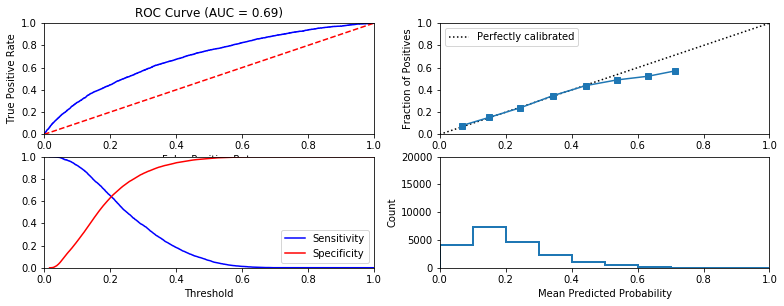


Similarity to LC grade ranking:  0.6941695239089776
Brier score: 0.15082598991760743
Were parameters on edge? : True
Score variations around CV search grid : 1.15737828657694
[0.79353333 0.79356667 0.79086667 0.79186667 0.79286667 0.7901
 0.79056667 0.79076667 0.79236667 0.78953333 0.79093333 0.79046667
 0.78943333 0.7906     0.7898     0.78816667 0.78926667 0.7881
 0.7857     0.789      0.787      0.79283333 0.79276667 0.7923
 0.79283333 0.7914     0.7934     0.7913     0.7905     0.7907
 0.78976667 0.7893     0.78853333 0.7896     0.7877     0.7872
 0.7883     0.78733333 0.789      0.78786667 0.78726667 0.78796667
 0.7949     0.79246667 0.7931     0.7917     0.791      0.78753333
 0.7917     0.79186667 0.78963333 0.79156667 0.7897     0.78716667
 0.79086667 0.7895     0.78813333 0.7897     0.79       0.78736667
 0.78913333 0.78606667 0.7884     0.79263333 0.79173333 0.7924
 0.79303333 0.79383333 0.79273333 0.79186667 0.79123333 0.7914
 0.7903     0.78983333 0.7902     0.7887     0.7

In [24]:
## Train and test a multi-layer perceptron classifier

mlp = MLPClassifier()
cv_parameters = {'solver': ['lbfgs'], 
                 'max_iter': [500,1000,1500], 
                 'alpha': 10.0 ** -np.arange(1, 7), 
                 'hidden_layer_sizes':np.arange(5, 12)}

mlp = fit_classification(mlp, data_dict, cv_parameters, 'Multi-layer perceptron')

## Train and Test logistic regression model with features derived by LendingClub

  Model: l1-regularized with lendingClub-defined feature
Fit time: 0.57 seconds
Optimal parameters:
{'C': 0.01}

Accuracy-maximizing threshold was: 1
Accuracy:  0.7943
              precision    recall  f1-score   support

  No default     0.7943    1.0000    0.8854     15886
     Default     0.0000    0.0000    0.0000      4114

   micro avg     0.7943    0.7943    0.7943     20000
   macro avg     0.3972    0.5000    0.4427     20000
weighted avg     0.6309    0.7943    0.7032     20000



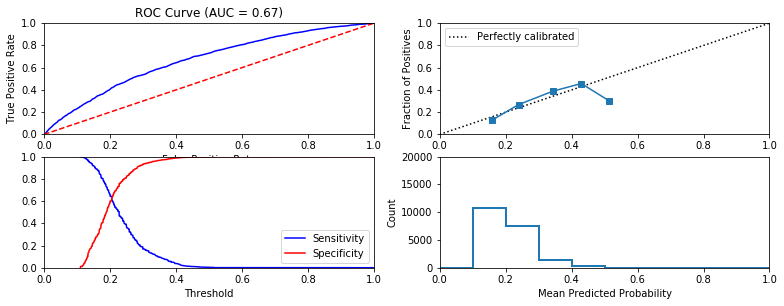


Similarity to LC grade ranking:  0.8573432693848415
Brier score: 0.15526125386020342
Were parameters on edge? : True
Score variations around CV search grid : 0.5487370669794283
[0.79576667 0.79216667 0.7914     0.7914     0.7914    ]


In [25]:
## Find a lendingClub-defined feature and train a l1-regularized logistic regression model on data with only that feature
a_lendingclub_feature = 'int_rate'

data_dict = prepare_data(feature_subset = a_lendingclub_feature)
lc1_only_logistic = LogisticRegression(penalty='l1')
cv_parameters = {'C': [0.01, 0.1, 1, 10, 100]}
lc1_only_logistic = fit_classification(lc1_only_logistic, data_dict, cv_parameters, 'l1-regularized with lendingClub-defined feature')

  Model: l2-regularized with lendingClub-defined feature
Fit time: 0.45 seconds
Optimal parameters:
{'C': 0.01}

Accuracy-maximizing threshold was: 1
Accuracy:  0.7943
              precision    recall  f1-score   support

  No default     0.7943    1.0000    0.8854     15886
     Default     0.0000    0.0000    0.0000      4114

   micro avg     0.7943    0.7943    0.7943     20000
   macro avg     0.3972    0.5000    0.4427     20000
weighted avg     0.6309    0.7943    0.7032     20000



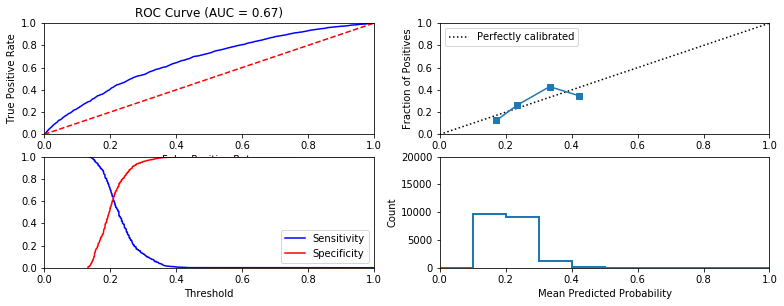


Similarity to LC grade ranking:  0.8573432693848415
Brier score: 0.15641817594775773
Were parameters on edge? : True
Score variations around CV search grid : 0.5654923972688747
[0.79576667 0.793      0.79126667 0.7914     0.7914    ]


In [26]:
## train a l2-regularized logistic regression model on data with only that feature
lc2_only_logistic = LogisticRegression(penalty='l2')
cv_parameters = {'C': [0.01, 0.1, 1, 10, 100]}

lc2_only_logistic = fit_classification(lc2_only_logistic, data_dict, cv_parameters, 'l2-regularized with lendingClub-defined feature')

## Train and test all the models you have tried previously after removing features derived by LendingClub 

In [27]:
## define your set of features to use in different models
your_features = ['loan_amnt', 'funded_amnt', 'term', 'emp_length',
'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status',
'purpose', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'open_acc', 'pub_rec',
'fico_range_high', 'fico_range_low', 'revol_bal', 'revol_util', 'total_pymnt',
'last_pymnt_d', 'recoveries']
# prepare the train, test data for training models
data_dict = prepare_data(feature_subset = your_features)

  Model: Naive Bayes Classifier
Fit time: 0.45 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 1
Accuracy:  0.7943
              precision    recall  f1-score   support

  No default     0.7943    1.0000    0.8854     15886
     Default     0.0000    0.0000    0.0000      4114

   micro avg     0.7943    0.7943    0.7943     20000
   macro avg     0.3972    0.5000    0.4427     20000
weighted avg     0.6309    0.7943    0.7032     20000



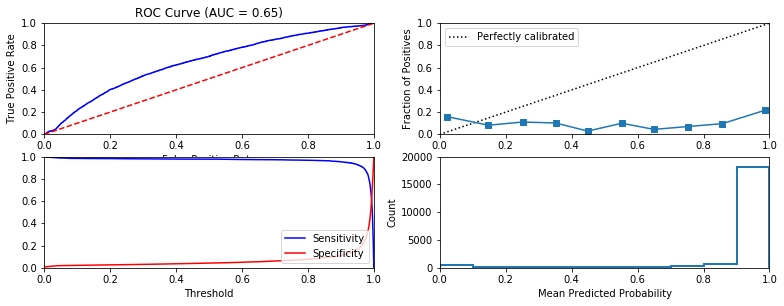


Similarity to LC grade ranking:  0.42407655179659265
Brier score: 0.7251001583762051
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.40416667]


In [28]:
## Train and test a naive bayes classifier

gnb = GaussianNB()
gnb = fit_classification(gnb, data_dict, model_name="Naive Bayes Classifier")

  Model: L1 regularized logistic regression
Fit time: 36.91 seconds
Optimal parameters:
{'C': 0.1}

Accuracy-maximizing threshold was: 0.4904012365971988
Accuracy:  0.7959
              precision    recall  f1-score   support

  No default     0.7983    0.9943    0.8856     15886
     Default     0.5748    0.0299    0.0568      4114

   micro avg     0.7959    0.7959    0.7959     20000
   macro avg     0.6865    0.5121    0.4712     20000
weighted avg     0.7523    0.7959    0.7151     20000



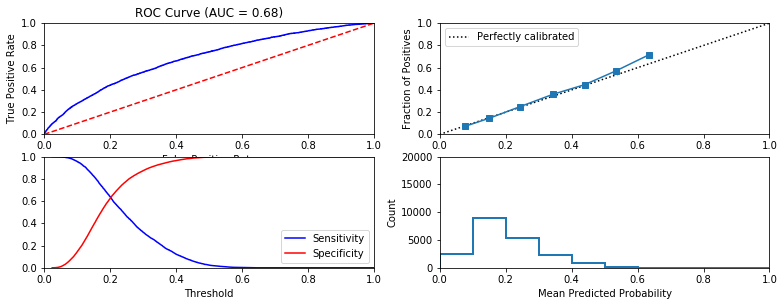


Similarity to LC grade ranking:  0.48584079076406383
Brier score: 0.15164036251715615
Were parameters on edge? : False
Score variations around CV search grid : 0.03769002052013208
[0.79576667 0.79596667 0.79576667 0.79566667 0.79566667]


In [29]:
## Train and test a l_1 regularized logistic regression classifier

l1_afterRemoving_logistic = LogisticRegression(penalty='l1')
cv_parameters = {'C': [0.01, 0.1, 1, 10, 100]}

l1_afterRemoving_logistic = fit_classification(l1_afterRemoving_logistic, data_dict, cv_parameters, 'L1 regularized logistic regression')

  Model: L2 regularized logistic regression
Fit time: 4.56 seconds
Optimal parameters:
{'C': 1}

Accuracy-maximizing threshold was: 0.5047044046162114
Accuracy:  0.79595
              precision    recall  f1-score   support

  No default     0.7982    0.9945    0.8856     15886
     Default     0.5789    0.0294    0.0560      4114

   micro avg     0.7960    0.7960    0.7960     20000
   macro avg     0.6886    0.5119    0.4708     20000
weighted avg     0.7531    0.7960    0.7150     20000



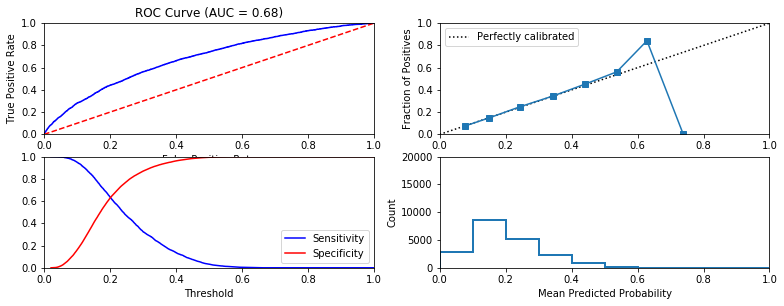


Similarity to LC grade ranking:  0.4853484630102659
Brier score: 0.1515111634755226
Were parameters on edge? : False
Score variations around CV search grid : 0.020942408376961045
[0.79576667 0.79573333 0.79583333 0.79566667 0.79566667]


In [30]:
## Train and test a l_2 regularized logistic regression classifier

l2_afterRemoving_logistic = LogisticRegression(penalty='l2')
cv_parameters = {'C': [0.01, 0.1, 1, 10, 100]}

l2_afterRemoving_logistic = fit_classification(l2_afterRemoving_logistic, data_dict, cv_parameters, 'L2 regularized logistic regression')

  Model: Decision tree
Fit time: 6.74 seconds
Optimal parameters:
{'criterion': 'entropy', 'max_depth': 4}

Accuracy-maximizing threshold was: 1
Accuracy:  0.7943
              precision    recall  f1-score   support

  No default     0.7943    1.0000    0.8854     15886
     Default     0.0000    0.0000    0.0000      4114

   micro avg     0.7943    0.7943    0.7943     20000
   macro avg     0.3972    0.5000    0.4427     20000
weighted avg     0.6309    0.7943    0.7032     20000



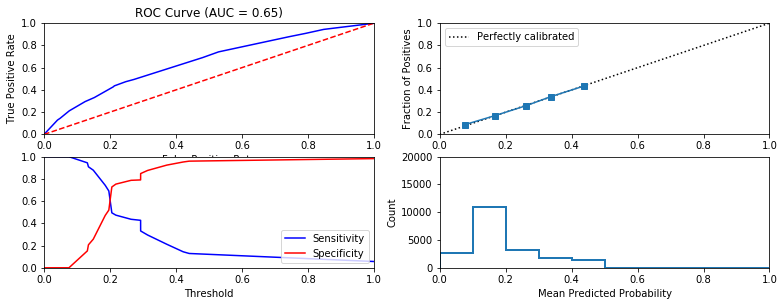


Similarity to LC grade ranking:  0.42760809333326405
Brier score: 0.15429588587773396
Were parameters on edge? : True
Score variations around CV search grid : 1.851929442326216
[0.79493333 0.79286667 0.78926667 0.78776667 0.78083333 0.79556667
 0.79356667 0.79196667 0.7874     0.78626667]


In [31]:
## Train and test a decision tree classifier

decision_tree_afterRemoving = DecisionTreeClassifier()
cv_parameters = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8]}

decision_tree_afterRemoving = fit_classification(decision_tree_afterRemoving, data_dict, cv_parameters, 'Decision tree')

  Model: Random forest
Fit time: 1319.8 seconds
Optimal parameters:
{'criterion': 'gini', 'max_depth': 7, 'max_features': 'auto', 'n_estimators': 200}

Accuracy-maximizing threshold was: 0.34521551761255187
Accuracy:  0.7936
              precision    recall  f1-score   support

  No default     0.8061    0.9746    0.8824     15886
     Default     0.4912    0.0946    0.1586      4114

   micro avg     0.7936    0.7936    0.7936     20000
   macro avg     0.6486    0.5346    0.5205     20000
weighted avg     0.7413    0.7936    0.7335     20000



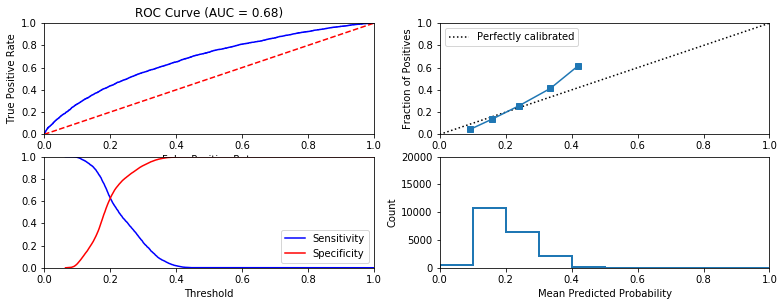


Similarity to LC grade ranking:  0.479883458837231
Brier score: 0.15352370691863615
Were parameters on edge? : True
Score variations around CV search grid : 0.012564918746857388
[0.79576667 0.79576667 0.79576667 0.79576667 0.79576667 0.79576667
 0.79576667 0.79576667 0.79576667 0.79576667 0.79576667 0.79576667
 0.79576667 0.79576667 0.79576667 0.79576667 0.79576667 0.79576667
 0.79586667 0.79583333 0.7958     0.7958     0.79576667 0.79576667
 0.7958     0.79586667 0.79586667 0.79586667 0.79583333 0.7958
 0.79576667 0.79576667 0.79576667 0.79576667 0.79576667 0.79576667
 0.79576667 0.79576667 0.79576667 0.79576667 0.79576667 0.79576667
 0.79576667 0.79576667 0.79576667 0.79576667 0.79576667 0.79576667
 0.7958     0.79576667 0.79576667 0.7958     0.79576667 0.79576667
 0.79583333 0.79583333 0.79583333 0.79583333 0.79583333 0.79583333]


In [32]:
## Train and test a random forest classifier

random_forest_afterRemoving = RandomForestClassifier()
cv_parameters = {'n_estimators': [200, 500],
                'max_features': ['auto', 'sqrt', 'log2'],
                'max_depth' : [4,5,6,7,8],
                'criterion' :['gini', 'entropy']}

random_forest_afterRemoving = fit_classification(random_forest_afterRemoving, data_dict, cv_parameters, 'Random forest')

  Model: Multi-layer perceptron
Fit time: 3475.87 seconds
Optimal parameters:
{'alpha': 1e-05, 'hidden_layer_sizes': 7, 'max_iter': 1000, 'solver': 'lbfgs'}

Accuracy-maximizing threshold was: 0.4877479227742808
Accuracy:  0.7947
              precision    recall  f1-score   support

  No default     0.8014    0.9859    0.8841     15886
     Default     0.5088    0.0564    0.1015      4114

   micro avg     0.7947    0.7947    0.7947     20000
   macro avg     0.6551    0.5211    0.4928     20000
weighted avg     0.7412    0.7947    0.7231     20000



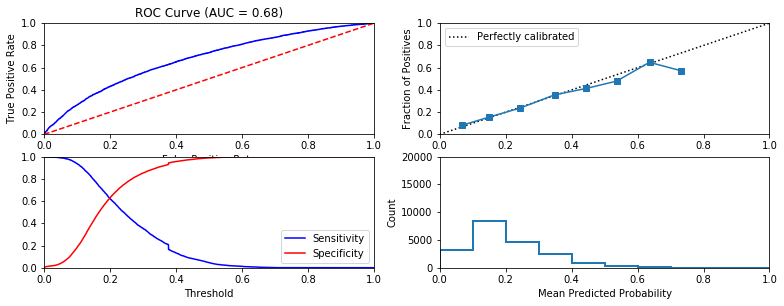


Similarity to LC grade ranking:  0.46513109580104134
Brier score: 0.15270783003655766
Were parameters on edge? : True
Score variations around CV search grid : 0.9228575024120101
[0.79426667 0.7939     0.79313333 0.7917     0.79353333 0.79333333
 0.79283333 0.7923     0.7918     0.79203333 0.7914     0.7914
 0.79146667 0.793      0.79166667 0.7893     0.78823333 0.78886667
 0.7901     0.7897     0.78926667 0.79433333 0.79283333 0.79356667
 0.79123333 0.7925     0.7926     0.7918     0.79096667 0.7921
 0.79176667 0.7915     0.7912     0.79216667 0.79226667 0.79023333
 0.7907     0.79056667 0.78913333 0.7907     0.78866667 0.79113333
 0.79266667 0.79283333 0.79393333 0.79326667 0.79276667 0.7927
 0.79113333 0.79263333 0.79266667 0.79       0.79223333 0.7923
 0.78953333 0.79056667 0.7896     0.7911     0.7904     0.7914
 0.7904     0.79056667 0.78956667 0.7944     0.7941     0.79276667
 0.7942     0.7926     0.78956667 0.793      0.79203333 0.7915
 0.79223333 0.79136667 0.79166667 0.7912 

In [33]:
## Train and test a multi-layer perceptron classifier

mlp_afterRemoving = MLPClassifier()
cv_parameters = {'solver': ['lbfgs'], 
                 'max_iter': [500,1000,1500], 
                 'alpha': 10.0 ** -np.arange(1, 7), 
                 'hidden_layer_sizes':np.arange(5, 12)}

mlp_afterRemoving = fit_classification(mlp_afterRemoving, data_dict, cv_parameters, 'Multi-layer perceptron')

## Time stability test of YOURMODEL

  Model: L2 trained on 2010 model
Fit time: 0.11 seconds
Optimal parameters:
{'C': 0.01}

Accuracy-maximizing threshold was: 1
Accuracy:  0.8844285714285715
              precision    recall  f1-score   support

  No default     0.8844    1.0000    0.9387      6191
     Default     0.0000    0.0000    0.0000       809

   micro avg     0.8844    0.8844    0.8844      7000
   macro avg     0.4422    0.5000    0.4693      7000
weighted avg     0.7822    0.8844    0.8302      7000



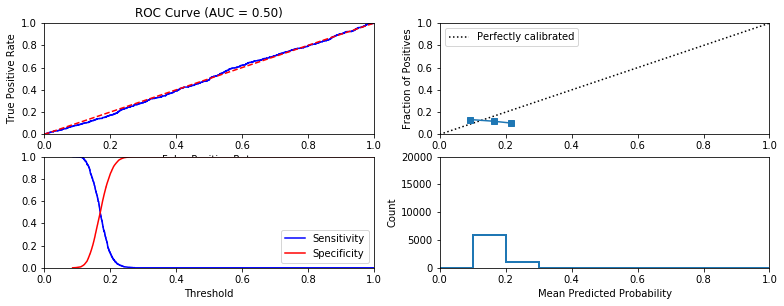


Similarity to LC grade ranking:  0.31599985563467486
Brier score: 0.1062735578113152
Were parameters on edge? : True
Score variations around CV search grid : 0.9972801450589204
[0.86713836 0.86713836 0.86320755 0.85927673 0.85849057]
  Model: L2 trained on 2016 model
Fit time: 0.9 seconds
Optimal parameters:
{'C': 1}

Accuracy-maximizing threshold was: 0.460219781248033
Accuracy:  0.8575714285714285
              precision    recall  f1-score   support

  No default     0.8854    0.9630    0.9226      6169
     Default     0.2138    0.0746    0.1106       831

   micro avg     0.8576    0.8576    0.8576      7000
   macro avg     0.5496    0.5188    0.5166      7000
weighted avg     0.8057    0.8576    0.8262      7000



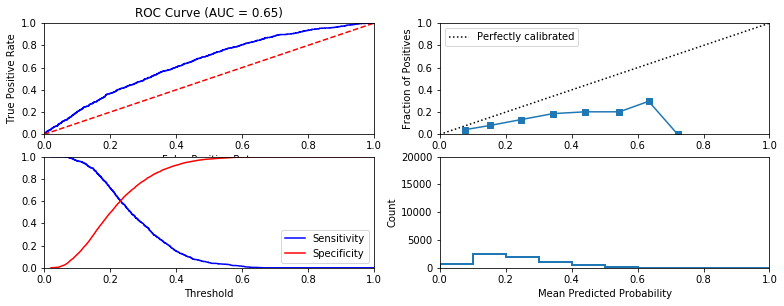


Similarity to LC grade ranking:  0.4261838564292629
Brier score: 0.11770787571734481
Were parameters on edge? : False
Score variations around CV search grid : 0.6998104679982463
[0.75677778 0.75988889 0.76211111 0.76133333 0.76122222]


{'model': LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='warn',
           n_jobs=None, penalty='l2', random_state=None, solver='warn',
           tol=0.0001, verbose=0, warm_start=False),
 'y_pred_labels': array([False, False, False, ..., False, False, False]),
 'y_pred_probs': array([0.23514149, 0.32191676, 0.27485026, ..., 0.14972354, 0.29888107,
        0.39851176])}

In [34]:
## Define the time window of your train and test data
start_date_train = datetime.date(2010,1,1)
end_date_train = datetime.date(2010,12,31)
start_date_test = datetime.date(2017,1,1)
end_date_test = datetime.date(2017,12,31)

data_dict_test = prepare_data(date_range_train = (start_date_train, end_date_train), 
                         date_range_test = (start_date_test, end_date_test),
                         n_samples_train = 9000, n_samples_test = 7000, feature_subset = your_features)

## Train and test YOURMODEL using this data
YOURMODEL = LogisticRegression(penalty='l2')
cv_parameters = {'C': [0.01, 0.1, 1, 10, 100]}

fit_classification(YOURMODEL, data_dict_test, cv_parameters, 'L2 trained on 2010 model')


start_date_train = datetime.date(2016,1,1)
end_date_train = datetime.date(2016,12,31)
start_date_test = datetime.date(2017,1,1)
end_date_test = datetime.date(2017,12,31)


data_dict_test_2016 = prepare_data(date_range_train = (start_date_train, end_date_train), 
                         date_range_test = (start_date_test, end_date_test),
                         n_samples_train = 9000, n_samples_test = 7000, feature_subset = your_features)



fit_classification(YOURMODEL, data_dict_test_2016, cv_parameters, 'L2 trained on 2016 model')


## Train and test YOURMODEL on the original data

  Model: L2 trained on original data
Fit time: 4.96 seconds
Optimal parameters:
{'C': 1}

Accuracy-maximizing threshold was: 0.5047044046162114
Accuracy:  0.79595
              precision    recall  f1-score   support

  No default     0.7982    0.9945    0.8856     15886
     Default     0.5789    0.0294    0.0560      4114

   micro avg     0.7960    0.7960    0.7960     20000
   macro avg     0.6886    0.5119    0.4708     20000
weighted avg     0.7531    0.7960    0.7150     20000



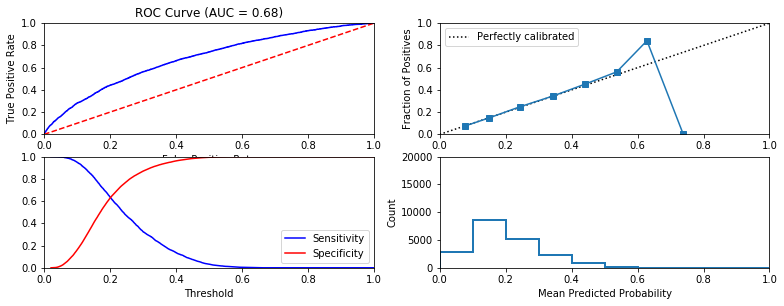


Similarity to LC grade ranking:  0.4853484630102659
Brier score: 0.1515111634755226
Were parameters on edge? : False
Score variations around CV search grid : 0.020942408376961045
[0.79576667 0.79573333 0.79583333 0.79566667 0.79566667]


{'model': LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='warn',
           n_jobs=None, penalty='l2', random_state=None, solver='warn',
           tol=0.0001, verbose=0, warm_start=False),
 'y_pred_labels': array([False, False, False, ..., False, False, False]),
 'y_pred_probs': array([0.16117147, 0.20781077, 0.10894464, ..., 0.09467537, 0.35656955,
        0.11628107])}

In [35]:
YOURMODEL = LogisticRegression(penalty='l2')
cv_parameters = {'C': [0.01, 0.1, 1, 10, 100]}

fit_classification(YOURMODEL, data_dict, cv_parameters, 'L2 trained on original data')


## Test regression models

In [36]:
def fit_regression(model, data_dict,
                      cv_parameters = {},
                      separate = False, 
                      model_name = None,
                      random_state = default_seed,
                      output_to_file = True,
                      print_to_screen = True):
    '''
    This function will fit a regression model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - separate: a Boolean variable indicating whether we fit models for 
                  defaulted and non-defaulted loans separately
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over      
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    This function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - model: the best fitted model
      - predicted_return: prediction result based on the test set
      - predicted_regular_return: prediction result for non-defaulted loans (valid if separate == True)
      - predicted_default_return: prediction result for defaulted loans (valid if separate == True)
      - r2_scores: the testing r2_score(s) for the best fitted model
    '''
    
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    
    X_train = data_dict['X_train']
    filter_train = data_dict['train_set']  

    X_test = data_dict['X_test']
    filter_test = data_dict['test_set']
    out = {}
    
    for ret_col in col_list:
        
        y_train = data.loc[filter_train, ret_col].as_matrix()
        y_test = data.loc[filter_test, ret_col].as_matrix() 

        # --------------------------
        #   Step 2 - Fit the model
        # --------------------------

        if separate:
            outcome_train = data.loc[filter_train, 'outcome']
            outcome_test = data.loc[filter_test, 'outcome']

            # Train two separate regressors for defaulted and non-defaulted loans
            X_train_0 = X_train[outcome_train == False]
            y_train_0 = y_train[outcome_train == False]
            X_test_0 = X_test[outcome_test == False]
            y_test_0 = y_test[outcome_test == False]

            X_train_1 = X_train[outcome_train == True]
            y_train_1 = y_train[outcome_train == True]
            X_test_1 = X_test[outcome_test == True]
            y_test_1 = y_test[outcome_test == True]

            cv_model_0 = GridSearchCV(model, cv_parameters, scoring='r2')
            cv_model_1 = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model_0.fit(X_train_0, y_train_0)
            cv_model_1.fit(X_train_1, y_train_1)
            end_time = time.time()

            best_model_0 = cv_model_0.best_estimator_
            best_model_1 = cv_model_1.best_estimator_
            
            if print_to_screen:

                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print("model_0:",cv_model_0.best_params_, "model_1",cv_model_1.best_params_)

            predicted_regular_return = best_model_0.predict(X_test)
            predicted_default_return = best_model_1.predict(X_test)
            
            if print_to_screen:
                print("")
                print("Testing r2 scores:")
            # Here we use different testing set to report the performance
            test_scores = {'model_0':r2_score(y_test_0,best_model_0.predict(X_test_0)),
                              'model_1':r2_score(y_test_1,best_model_1.predict(X_test_1))}
            if print_to_screen:
                print("model_0:", test_scores['model_0'])
                print("model_1:", test_scores['model_1'])

            cv_objects = {'model_0':cv_model_0, 'model_1':cv_model_1}
            out[ret_col] = { 'model_0':best_model_0, 'model_1':best_model_1, 'predicted_regular_return':predicted_regular_return,
                      'predicted_default_return':predicted_default_return,'r2_scores':test_scores }

        else:
            cv_model = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model.fit(X_train, y_train)
            end_time = time.time()

            best_model = cv_model.best_estimator_
            
            if print_to_screen:
                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print(cv_model.best_params_)

            predicted_return = best_model.predict(X_test)
            test_scores = {'model':r2_score(y_test,predicted_return)}
            if print_to_screen:
                print("")
                print("Testing r2 score:", test_scores['model'])

            cv_objects = {'model':cv_model}
            out[ret_col] = {'model':best_model, 'predicted_return':predicted_return, 'r2_scores':r2_score(y_test,predicted_return)}

        # Output the results to a file
        if output_to_file:
            for i in cv_objects:
                # Check whether any of the CV parameters are on the edge of
                # the search space
                opt_params_on_edge = find_opt_params_on_edge(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::search_on_edge", opt_params_on_edge)
                if print_to_screen:
                    print("Were parameters on edge (" + i + ") : " + str(opt_params_on_edge))

                # Find out how different the scores are for the different values
                # tested for by cross-validation. If they're not too different, then
                # even if the parameters are off the edge of the search grid, we should
                # be ok
                score_variation = find_score_variation(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::score_variation", score_variation)
                if print_to_screen:
                    print("Score variations around CV search grid (" + i + ") : " + str(score_variation))

                # Print out all the scores
                dump_to_output(model_name + "::all_cv_scores", str(cv_objects[i].cv_results_['mean_test_score']))
                if print_to_screen:
                    print("All test scores : " + str(cv_objects[i].cv_results_['mean_test_score']) )

                # Dump the AUC to file
                dump_to_output( model_name + "::" + ret_col + "::r2", test_scores[i] )

    return out

### $l_1$ regularized linear regression

In [37]:
## First, trying l1 regularized linear regression with hyper-parameters

cv_parameters = {'alpha': [0.01, 0.1, 1, 10, 100]}
reg_lasso = linear_model.Lasso()
reg_lasso = fit_regression(reg_lasso, data_dict, cv_parameters, model_name="L1 regularized linear regression")

  Model: L1 regularized linear regression  Return column: ret_PESS
Fit time: 1.14 seconds
Optimal parameters:
{'alpha': 0.01}

Testing r2 score: -6.035447006436101e-05
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -0.0
All test scores : [-0.14698396 -0.14698396 -0.14698396 -0.14698396 -0.14698396]
  Model: L1 regularized linear regression  Return column: ret_OPT
Fit time: 1.08 seconds
Optimal parameters:
{'alpha': 0.01}

Testing r2 score: -3.314087001626831e-05
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -0.0
All test scores : [-0.02741458 -0.02741458 -0.02741458 -0.02741458 -0.02741458]
  Model: L1 regularized linear regression  Return column: ret_INTa
Fit time: 1.12 seconds
Optimal parameters:
{'alpha': 0.01}

Testing r2 score: -4.618619461727036e-05
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -0.0
All test scores : [-0.12918503 -0.12918503 -0.12918503 -0.

### $l_2$ regularized linear regressor

In [38]:
## trying l2 regularized linear regression with hyper-parameters
cv_parameters = {'alpha': [0.01, 0.1, 1, 10, 100]}
reg_ridge = linear_model.Ridge()
reg_ridge = fit_regression(reg_ridge, data_dict, cv_parameters, model_name="L2 regularized linear regression")

  Model: L2 regularized linear regression  Return column: ret_PESS
Fit time: 0.94 seconds
Optimal parameters:
{'alpha': 0.01}

Testing r2 score: 0.028939205034868132
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -1.2767417542396955
All test scores : [-0.12027822 -0.12028733 -0.12033565 -0.12042739 -0.12181386]
  Model: L2 regularized linear regression  Return column: ret_OPT
Fit time: 0.92 seconds
Optimal parameters:
{'alpha': 100}

Testing r2 score: 0.014268478751878422
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -3.3654018934768875
All test scores : [-0.02420801 -0.02420038 -0.02413938 -0.02389328 -0.02341984]
  Model: L2 regularized linear regression  Return column: ret_INTa
Fit time: 0.96 seconds
Optimal parameters:
{'alpha': 0.01}

Testing r2 score: 0.03298054849613563
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -1.2770698680195298
All test scores : [-0

### Multi-layer perceptron regressor

In [39]:
## trying multi-layer perceptron regression with hyper-parameters
reg_mlp = MLPRegressor()
cv_parameters = { 'max_iter': [500,1000,1500], 
                 'alpha': 10.0 ** -np.arange(1, 7), 
                 'hidden_layer_sizes':np.arange(5, 12),
                'activation': ["logistic", "relu", "tanh"]
                }

reg_mlp = fit_regression(reg_mlp, data_dict, cv_parameters, model_name = 'Multi-layer peceptron regressor')

  Model: Multi-layer peceptron regressor  Return column: ret_PESS
Fit time: 1279.46 seconds
Optimal parameters:
{'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': 5, 'max_iter': 1000}

Testing r2 score: 0.020291157878222887
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -190.6110318571314
All test scores : [-0.12854063 -0.1504103  -0.19558672 -0.12716657 -0.15125316 -0.18238291
 -0.11603797 -0.13575246 -0.1416651  -0.13777147 -0.10047925 -0.13318939
 -0.10216541 -0.10585415 -0.12635847 -0.11355372 -0.14682517 -0.1327673
 -0.13725162 -0.13323771 -0.15182831 -0.2455535  -0.16902614 -0.20697101
 -0.1699462  -0.14833187 -0.16470818 -0.09703068 -0.15925577 -0.16627344
 -0.13074661 -0.12534801 -0.13172446 -0.11843996 -0.15544195 -0.13854839
 -0.1502523  -0.13088053 -0.12815301 -0.11129222 -0.1306485  -0.13059016
 -0.16918264 -0.15290924 -0.15501061 -0.15477339 -0.12299506 -0.13893356
 -0.1572998  -0.1301312  -0.12503145 -0.15267953 -0.11924972

  Model: Multi-layer peceptron regressor  Return column: ret_INTa
Fit time: 1041.02 seconds
Optimal parameters:
{'activation': 'logistic', 'alpha': 1e-05, 'hidden_layer_sizes': 11, 'max_iter': 1000}

Testing r2 score: 0.032710994494219436
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -448.76221916954256
All test scores : [-0.12950808 -0.13285154 -0.11109673 -0.1325824  -0.10713516 -0.11817032
 -0.11658237 -0.12421778 -0.1465954  -0.11662196 -0.14099034 -0.13965114
 -0.11002229 -0.12790646 -0.09051726 -0.14631908 -0.11838334 -0.1070757
 -0.13872345 -0.11483343 -0.12186084 -0.19179682 -0.1053752  -0.11714082
 -0.08830375 -0.12017462 -0.12684132 -0.08105467 -0.12432812 -0.1840838
 -0.12745849 -0.14435942 -0.11227001 -0.11355258 -0.10324792 -0.10587722
 -0.11000924 -0.13035076 -0.16134531 -0.12188311 -0.13785086 -0.12824071
 -0.16048493 -0.14440951 -0.14448936 -0.13791256 -0.14458013 -0.13087995
 -0.12756373 -0.11948818 -0.17319667 -0.11840018 -0.0

### Random forest regressor

In [46]:
## trying random forest regression with hyper-parameters
reg_rf = RandomForestRegressor()
cv_parameters = {'n_estimators': [200, 500],
                'max_features': ['auto', 'sqrt', 'log2'],
                'max_depth' : [4,5,6,7,8],
               }

reg_rf = fit_regression(reg_rf, data_dict, cv_parameters, model_name = 'Random forest regressor')

  Model: Random forest regressor  Return column: ret_PESS
Fit time: 1240.04 seconds
Optimal parameters:
{'max_depth': 8, 'max_features': 'auto', 'n_estimators': 500}

Testing r2 score: 0.032511837191558035
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -11.198158450025858
All test scores : [-0.1251621  -0.12541631 -0.12962006 -0.12986517 -0.13108582 -0.13100955
 -0.12248663 -0.12200755 -0.12636581 -0.12662258 -0.1287426  -0.12802812
 -0.11996265 -0.12075436 -0.12432417 -0.12366235 -0.12557327 -0.12556552
 -0.1187112  -0.11856104 -0.12157155 -0.12132316 -0.12357581 -0.12309022
 -0.11820816 -0.11788488 -0.12035832 -0.1197306  -0.1208077  -0.1209621 ]
  Model: Random forest regressor  Return column: ret_OPT
Fit time: 1058.19 seconds
Optimal parameters:
{'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 500}

Testing r2 score: 0.017207744774865863
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -22.02608

## Test investment strategies 
Now we test several investment strategies using the learning models above

In [63]:
def test_investments(data_dict,
                        classifier = None,
                        regressor = None,
                        strategy = 'Random', 
                        num_loans = 1000,
                        random_state = default_seed,
                        output_to_file = True):
    '''
    This function tests a variety of investment methodologies and their returns. 
    It will run its tests on the loans defined by the test_set element of the data
    dictionary.
    
    It is currently able to test four strategies
      - random: invest in a random set of loans
      - default-based: score each loan by probability of default, and only invest
                 in the "safest" loans (i.e., those with the lowest probabilities
                 of default)
      - return-based: train a single regression model to predict the expected return
                    of loans in the past. Then, for loans we could invest in, simply
                    rank them by their expected returns and invest in that order.
      - default-& return-based: train two regression models to predict the expected return of
                   defaulted loans and non-defaulted loans in the training set. Then,
                   for each potential loan we could invest in, predict the probability
                   the loan will default, its return if it doesn't default and its
                   return if it does. Then, calculate a weighted combination of
                   the latter using the former to find a predicted return. Rank the
                   loans by this expected return, and invest in that order
    
    It expects the following parameters
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - classifier: a fitted model object which is returned by the fit_classification function.
      - regressor: a fitted model object which is returned by the fit_regression function.
      - strategy: the name of the strategy; one of the three listed above
      - num_loans: the number of loans to be included in the test portfolio
      - num_samples: the number of random samples used to compute average return ()   
      - random_state: the random seed to use when selecting a subset of rows
      - output_to_file: if the results will be saved to the output file
      
    The function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - strategy: the name of the strategy
      - average return: the return of the strategy based on the testing set
      - test data: the updated Dataframe of testing data. Useful in the optimization section
    '''
    
    np.random.seed(random_state)
    
    # Retrieve the rows that were used to train and test  the
    # classification model
    train_set = data_dict['train_set']
    test_set = data_dict['test_set']
    
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    
    # Create a dataframe for testing, including the score
    data_test = data.loc[test_set,:]
    out = {}
    
    for ret_col in col_list:    
    
        if strategy == 'Random':
            # Randomize the order of the rows in the datframe
            data_test = data_test.sample(frac = 1).reset_index(drop = True)

            ## Select num_loans to invest in
            pf_test = data_test[:num_loans][ret_col]

            ## Find the average return for these loans
            ret_test = pf_test.mean()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue
        
        elif strategy == 'Return-based':
            
            colname = 'predicted_return_' + ret_col 
            
            data_test[colname] = regressor[ret_col]['predicted_return']
            
            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            ## Pick num_loans loans
            pf_test = data_test[:num_loans][colname]

            ## Find their return
            ret_test = pf_test.mean()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue
            
        # Get the predicted scores, if the strategy is not Random or just Regression
        try:
            y_pred_score = classifier['y_pred_probs']
        except:
            y_pred_score = classifier['y_pred_score']

        data_test['score'] = y_pred_score


        if strategy == 'Default-based':
            # Sort the test data by the score
            data_test = data_test.sort_values(by='score').reset_index(drop = True)

            ## Select num_loans to invest in
            pf_test = data_test[:num_loans][ret_col]

            ## Find the average return for these loans
            ret_test = pf_test.mean()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue


        elif strategy == 'Default-return-based':

            # Load the predicted returns
            data_test['predicted_regular_return'] = regressor[ret_col]['predicted_regular_return']
            data_test['predicted_default_return'] = regressor[ret_col]['predicted_default_return']

            # Compute expectation
            colname = 'predicted_return_' + ret_col 
            
            data_test[colname] = ( (1-data_test.score)*data_test.predicted_regular_return + 
                                             data_test.score*data_test.predicted_default_return )

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            ## Pick num_loans loans
            pf_test = data_test[:num_loans][colname]

            ## Find their return
            ret_test = pf_test.mean()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        else:
            return 'Not a valid strategy'
        
    return out

In [55]:
## Test investment strategies using the best performing regressor

col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
test_strategy = 'Random'

print('strategy:',test_strategy)   
strat_rand = test_investments(data_dict, regressor=reg_rf, strategy=test_strategy)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_rand[ret_col]['average return']))

strategy: Random
ret_PESS: 0.0076934889708260516
ret_OPT: 0.04390025746100326
ret_INTa: 0.01964997310802962
ret_INTb: 0.05632147849242029


In [56]:
test_strategy = 'Default-based'

print('strategy:',test_strategy)
strat_def = test_investments(data_dict,classifier=random_forest_afterRemoving, regressor=reg_rf, strategy=test_strategy)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_def[ret_col]['average return']))

strategy: Default-based
ret_PESS: 0.017935483943767056
ret_OPT: 0.05022273925834934
ret_INTa: 0.019696850230498865
ret_INTb: 0.06013082444508844


In [57]:
test_strategy = 'Return-based'

print('strategy:',test_strategy)
strat_ret = test_investments(data_dict, regressor=reg_rf, strategy=test_strategy)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_ret[ret_col]['average return']))

strategy: Return-based
ret_PESS: 0.025411027327098004
ret_OPT: 0.06620600230669164
ret_INTa: 0.032138813766949804
ret_INTb: 0.06856175489283776


In [51]:
reg_separate = RandomForestRegressor()
cv_parameters = {'n_estimators': [200, 500],
                'max_features': ['auto', 'sqrt', 'log2'],
                'max_depth' : [4,5,6,7,8],
               }

reg_separate = fit_regression(reg_separate, data_dict, cv_parameters, model_name = 'Random forest', separate=True)

  Model: Random forest  Return column: ret_PESS
Fit time: 1038.84 seconds
Optimal parameters:
model_0: {'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 500} model_1 {'max_depth': 5, 'max_features': 'auto', 'n_estimators': 200}

Testing r2 scores:
model_0: 0.033709178347016366
model_1: 0.09470614416890932
Were parameters on edge (model_0) : True
Score variations around CV search grid (model_0) : -3.370948812828534
All test scores : [-0.43908764 -0.44019669 -0.43930258 -0.43918066 -0.44270258 -0.43908336
 -0.44209763 -0.43789224 -0.43124369 -0.43365459 -0.43583006 -0.43565393
 -0.43923061 -0.43762753 -0.43152338 -0.43065361 -0.43392836 -0.43390744
 -0.44007909 -0.44022644 -0.43010145 -0.42901646 -0.4318235  -0.43208785
 -0.44147685 -0.4422127  -0.42937445 -0.42826595 -0.42884336 -0.42982406]
Were parameters on edge (model_1) : True
Score variations around CV search grid (model_1) : -23.42087037526865
All test scores : [-0.22684446 -0.22855224 -0.27149032 -0.27154095 -0.27625641 -

In [66]:
test_strategy = 'Default-return-based'
print('strategy:',test_strategy)
strat_defret = test_investments(data_dict, classifier=random_forest_afterRemoving, regressor=reg_separate, strategy=test_strategy)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_defret[ret_col]['average return']))

strategy: Default-return-based
ret_PESS: 0.017395856213006888
ret_OPT: 0.07707042768948477
ret_INTa: 0.034447531910085455
ret_INTb: 0.0699246878944917


## Sensitivity test of portfolio size

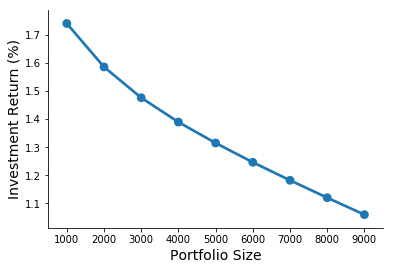

In [67]:
## Test the best-performing data-driven strategy on different portfolio sizes

result_sensitivity = []

## Vary the portfolio size from 1,000 to 10,000
for num_loans in list(range(1000,10000,1000)):

    reg_0 = test_investments(data_dict, classifier=random_forest_afterRemoving, regressor=reg_separate, strategy=test_strategy, num_loans=num_loans)
    result_sensitivity.append(reg_0['ret_PESS']['average return'])
    
result_sensitivity = np.array(result_sensitivity) * 100
sns.pointplot(np.array(list(range(1000,10000,1000))),result_sensitivity)
sns.despine()
plt.ylabel('Investment Return (%)',size = 14)
plt.xlabel('Portfolio Size',size = 14)
plt.show()